In [1]:
from IPython.display import HTML #Make all more readable 
HTML("<style>.container { width:100%;}</style>")

In [2]:
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
import dgl

from time import time

/home/david/VSCProjects/PI-GNN/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/david/VSCProjects/PI-GNN/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# local imports: we load a few general utility functions from `minimal_utils.py`.

from Utils_orig import(get_adjacency_matrix, saver, plotter, plotter_g, get_gnn, 
                      loss_func_color_hard, run_gnn_training, SyntheticDataset, chromatic_numbers)

In [4]:
# fix seed to ensure consistent results
SEED_VALUE = 0
random.seed(SEED_VALUE)        # seed python RNG
np.random.seed(SEED_VALUE)     # seed global NumPy RNG
torch.manual_seed(SEED_VALUE)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [5]:
# Specify the problem instance to solve and where to find the dataset(s) here:
TrPath="./data/input/COLOR/instances"
n_data=200
data_train = SyntheticDataset(TrPath, n_data)
print('Dataset pronto\n')

Building graph from contents of file: queen5_5.col
Dataset pronto



In [6]:
print(data_train.graphs[0].edges()[0].size())

torch.Size([320])


In [7]:
dict_graphs={data_train.fnames[i] : [data_train.graphs[i], data_train.nxgraphs[i]] for i in range(len(data_train.nxgraphs))}
#print(dict_graphs['myciel3.col'][1])

In [8]:
# Sample hyperparameters
if TORCH_DEVICE.type == 'cpu':  # example with CPU
    hypers = {
        'model': 'GraphConv',   # set either with 'GraphConv' or 'GraphSAGE'. It cannot take other input
        'dim_embedding': 64,
        'dropout': 0.1,
        'learning_rate': 0.0001,
        'hidden_dim': 64,
        'seed': SEED_VALUE
    }
else:                           # example with GPU
    hypers = {
        'model': 'GraphSAGE',
        'dim_embedding': 77,
        'dropout': 0.3784,
        'learning_rate': 0.02988,
        'hidden_dim': 32,
        'seed': SEED_VALUE
    }
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[16.0,9.0]
plt.rcParams['figure.dpi']=300

In [9]:
torch.set_printoptions(threshold=3705,linewidth=160)

In [10]:
probs=[]
best_colorings=[]
best_losses=[] 
final_colorings=[] 
final_losses=[] 
epoch_nums = []
names=[]
lossesses=[]
hard_lossesses=[]
chromss=[]

In [11]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

t_start = time()
for i in range(len(data_train)):
    try:
        # Default meta parameters
        solver_hypers = {
            'tolerance': 1e-3,           # Loss must change by more than tolerance, or add towards patience count
            'number_epochs': int(1e5),   # Max number training steps
            'patience': 10000,             # Number early stopping triggers before breaking loop
            'graph_file': data_train.fnames[i],  # Which problem is being solved
            'layer_agg_type': 'mean',    # How aggregate neighbors sampled within graphSAGE
            'number_classes': chromatic_numbers[data_train.fnames[i]]#data_train.GetChrom(i)#
        }

        # Combine into a single set
        hypers.update(solver_hypers)

        # Get adjacency matrix for use in calculations
        adj_ = get_adjacency_matrix(data_train.nxgraphs[i], TORCH_DEVICE, TORCH_DTYPE)

        # See minimal_utils.py for description. Constructs GNN and optimizer objects from given hypers. 
        # Initializes embedding layer to use as initial model input
        net, embed, optimizer = get_gnn(data_train.fnames[i],data_train.graphs[i], data_train.nxgraphs[i].number_of_nodes(), hypers, opt_hypers, TORCH_DEVICE, TORCH_DTYPE)

        #print(len(nx_graph.nodes()))
        name,losses,hard_losses,chroms, prob,best_coloring,best_loss,final_coloring,final_loss,epoch_num = run_gnn_training(
            hypers['graph_file'], data_train.nxgraphs[i], data_train.graphs[i], adj_, net, embed, 
            optimizer, hypers['number_epochs'], hypers['patience'], hypers['tolerance'], seed=SEED_VALUE)
        names.append(name) #all this cuz sometimes can't be processesd by net and triggers exception, cuzing different lengths.
        probs.append(prob)
        lossesses.append(losses)
        hard_lossesses.append(hard_losses)
        chromss.append(chroms)
        best_colorings.append(best_coloring)
        best_losses.append(best_loss)
        final_colorings.append(final_coloring)
        final_losses.append(final_loss)
        epoch_nums.append(epoch_num)

        runtime_gnn = round(time() - t_start, 4)

        # report results
        print(f'GNN runtime: {runtime_gnn}s')
    except IndexError:
        print(f'index error for graph {data_train.fnames[i]}')

Function get_gnn(): Setting seed to 0
Building GraphConv model for graph queen5_5.col, chrom number: 5...
Building ADAM-W optimizer for graph queen5_5.col...
Function run_gnn_training(): Setting seed to 0
Epoch 0 | Soft Loss: 32.87294  | ChroNu: 5 | time: 0.0161 | Discrete Cost:160
Epoch 500 | Soft Loss: 31.99464  | ChroNu: 5 | time: 4.0348 | Discrete Cost:28
Epoch 1000 | Soft Loss: 31.91972  | ChroNu: 5 | time: 8.0477 | Discrete Cost:21
Epoch 1500 | Soft Loss: 31.16745  | ChroNu: 5 | time: 12.068 | Discrete Cost:29
Epoch 2000 | Soft Loss: 28.50724  | ChroNu: 4 | time: 16.1032 | Discrete Cost:27
Epoch 2500 | Soft Loss: 26.30061  | ChroNu: 5 | time: 20.1885 | Discrete Cost:24
Epoch 3000 | Soft Loss: 24.75019  | ChroNu: 5 | time: 24.1106 | Discrete Cost:20
Epoch 3500 | Soft Loss: 23.11136  | ChroNu: 5 | time: 28.1337 | Discrete Cost:20
Epoch 4000 | Soft Loss: 21.68607  | ChroNu: 5 | time: 32.9823 | Discrete Cost:17
Epoch 4500 | Soft Loss: 20.54071  | ChroNu: 5 | time: 37.6672 | Discrete 

saving loss of queen5_5.col
saving chroma of queen5_5.col
saving coloring of queen5_5.col
plotting losses of queen5_5.col
plotting predicted chromatic numbers of queen5_5.col
drawing coloured graph for queen5_5.col


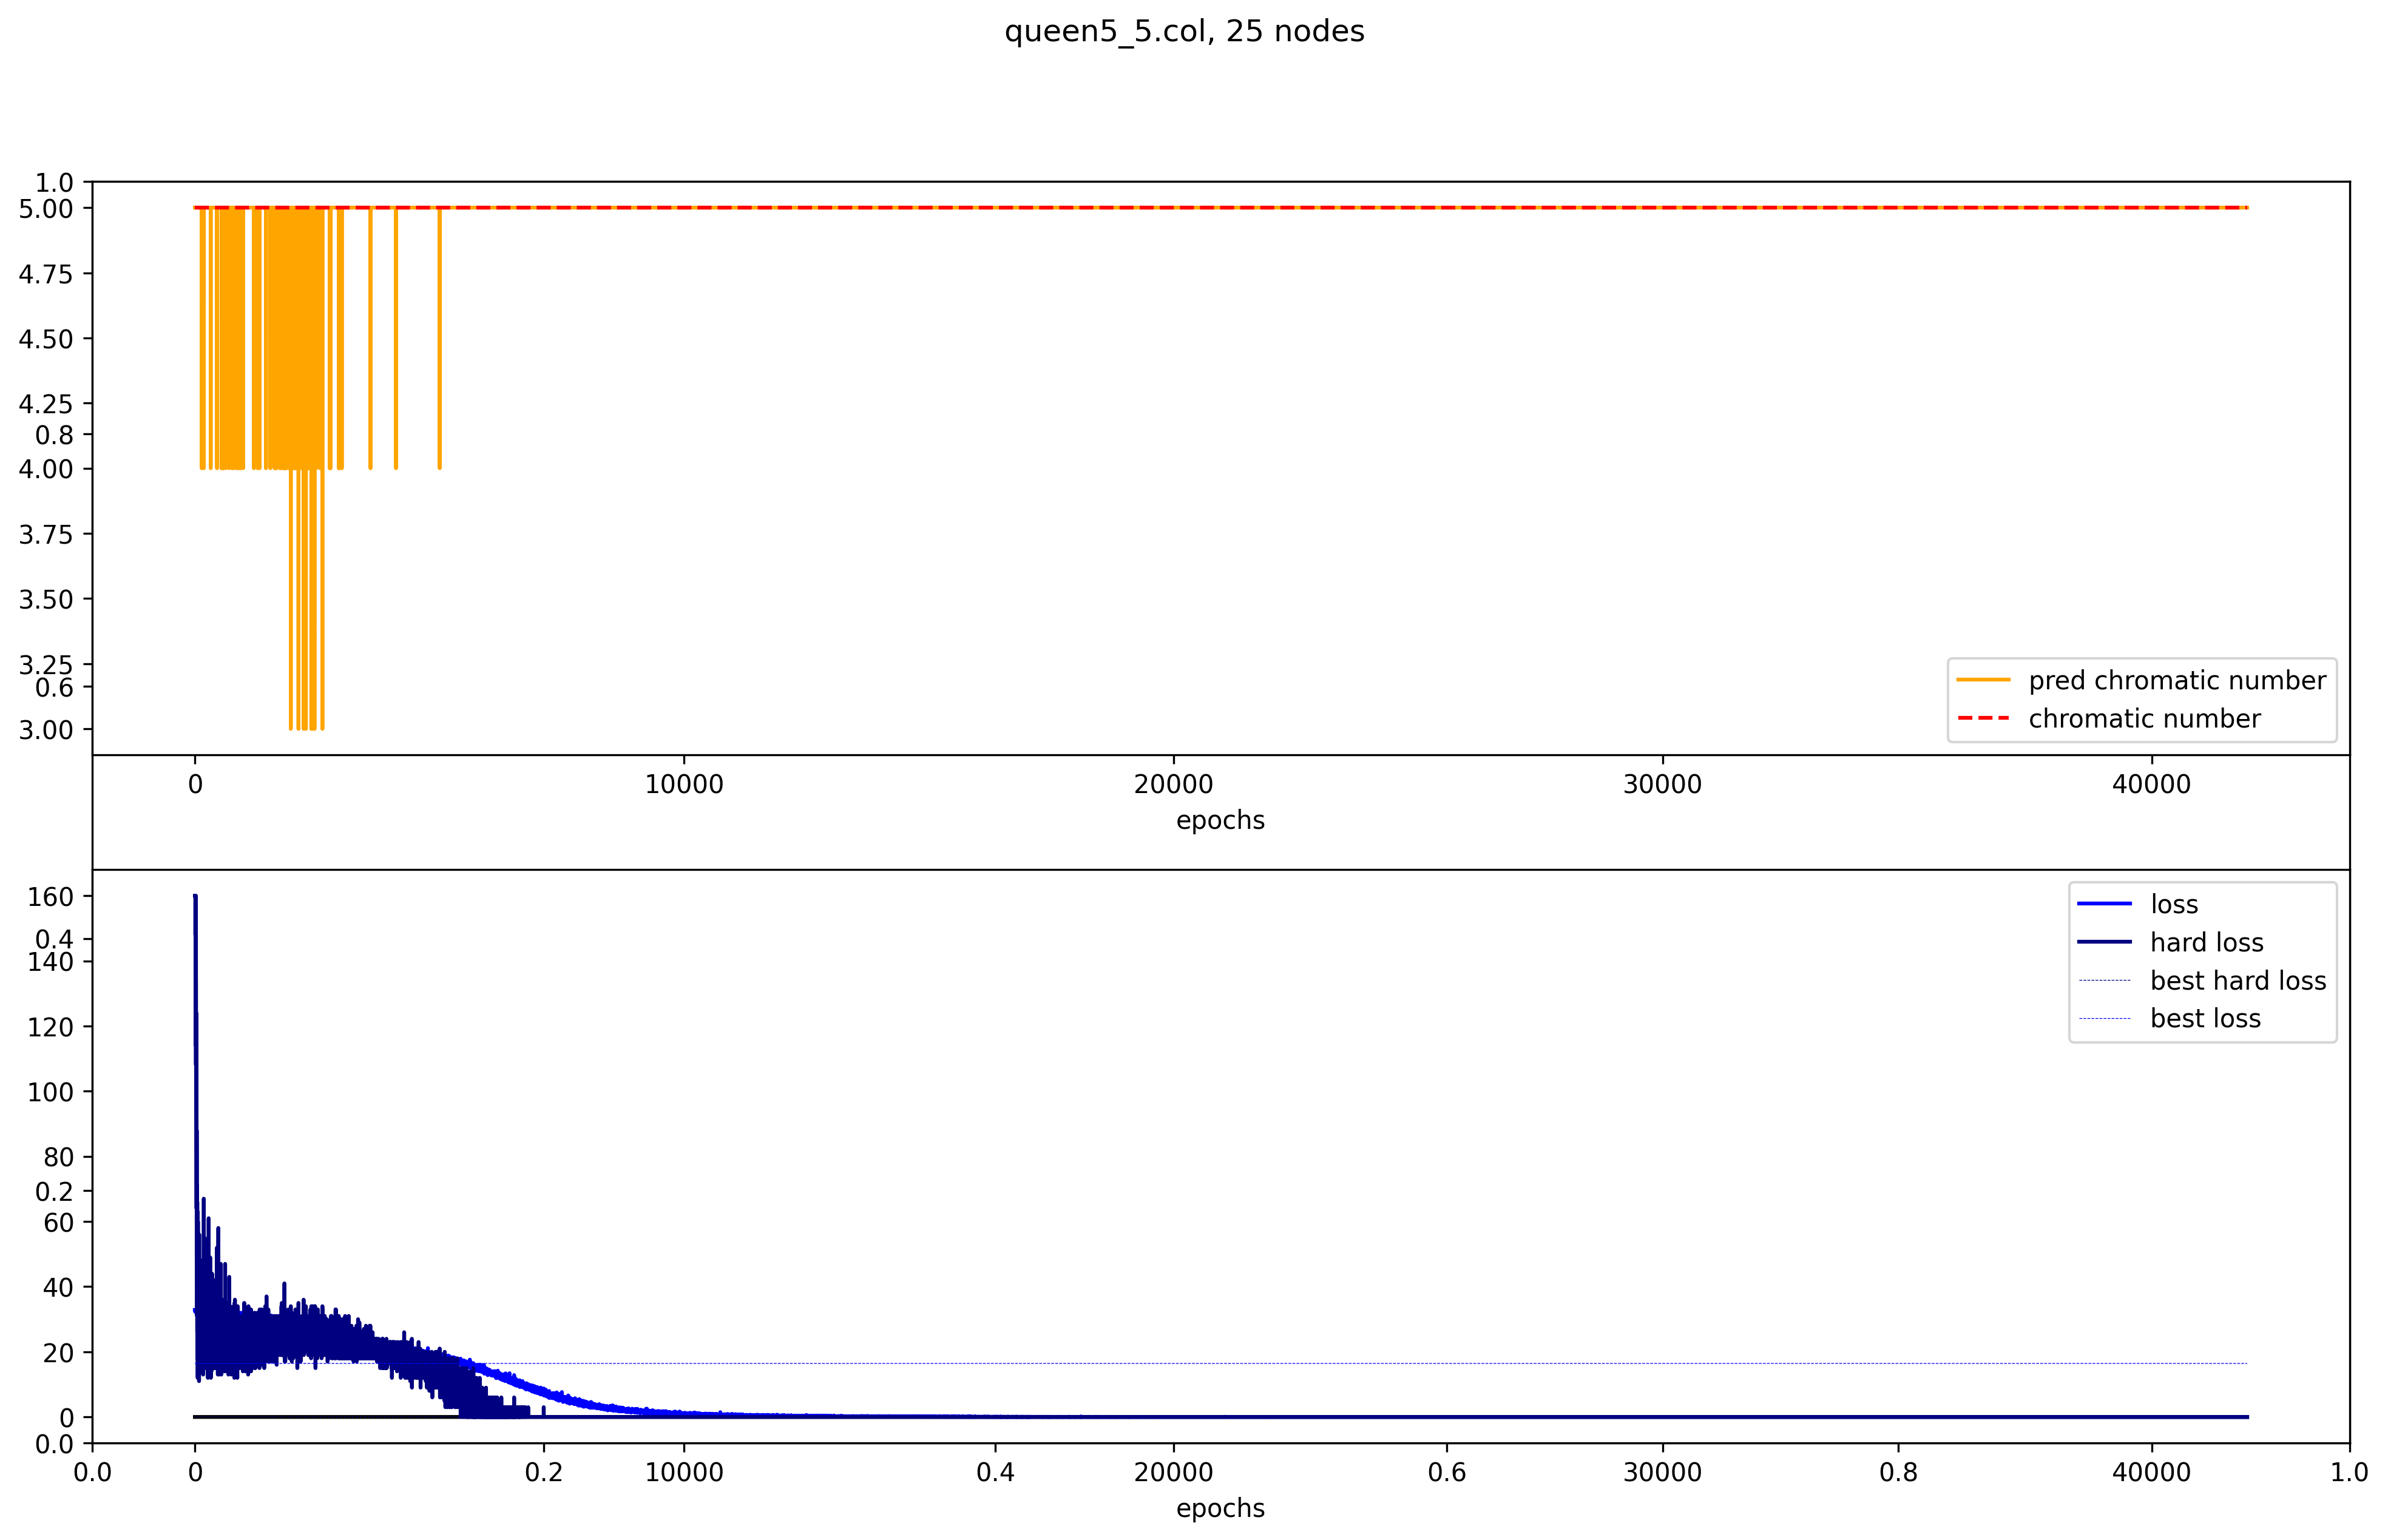

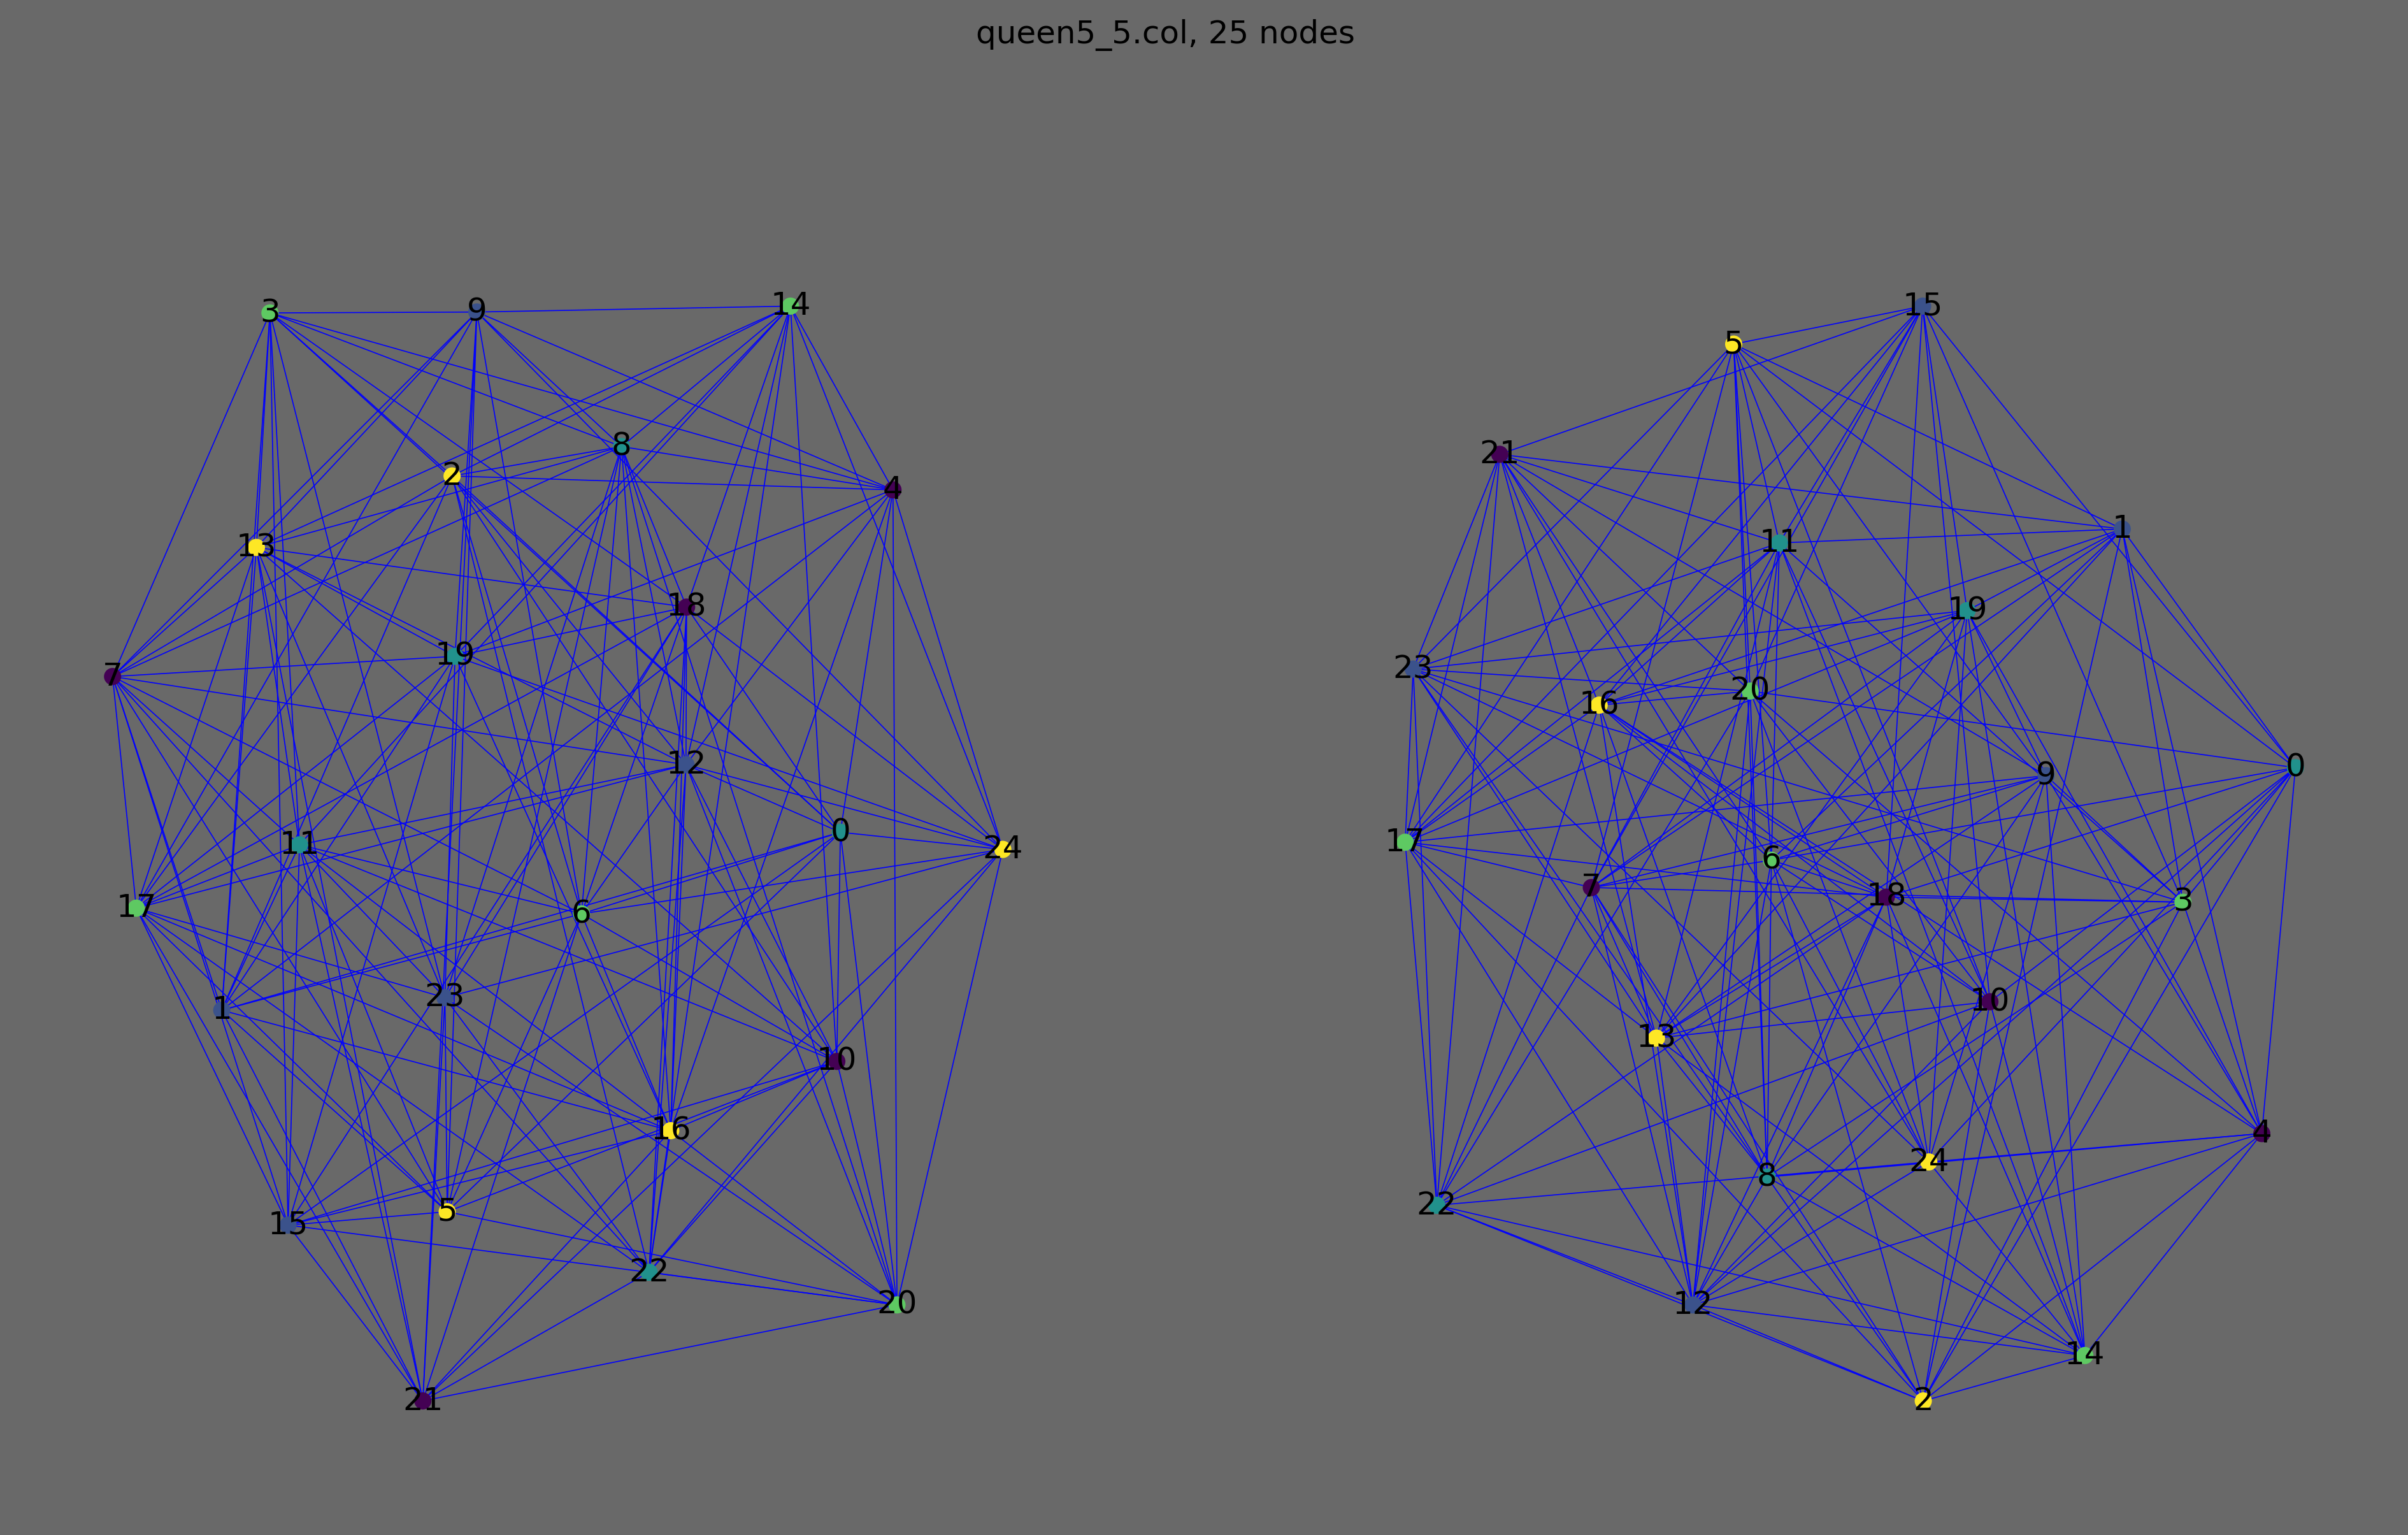

In [14]:
for i in range(len(names)):
    saver(lossesses[i], names[i], 'loss', hard_lossesses[i])
    saver(chromss[i], names[i], 'chroma')
    saver(best_colorings[i], names[i], 'coloring', final_colorings[i])
    plotter(names[i], len(dict_graphs[names[i]][0].nodes()),min(hard_lossesses[i]),best_losses[i]) #2nd entry is n_nodes.
    plotter_g(names[i], graph=dict_graphs[names[i]][1]) #[0] indicates nxgraph, [1] would indicate gdlgraph

In [ ]:
# check for color violations
best_cost_hard = loss_func_color_hard(best_coloring, nx_graph)

print(f'Best (hard) cost of coloring (n_class={hypers["number_classes"]}): {best_cost_hard}')

In [ ]:
plotter_g('games120.col', graph=dict_graphs['games120.col'][1]) #[0] indicates nxgraph, [1] would indicate gdlgraph